In [19]:
import jax.numpy as jnp
import numpyro
import pandas as pd

# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
from lightweight_mmm.config import feature_store_origin, revenue_column, media_columns, exogenous_columns
from lightweight_mmm.tesa_utils import get_exogenous_df, get_media_df, get_revenue_df
import os

In [20]:
extra_variables_df = get_exogenous_df(feature_store_origin)
extra_variables_df = extra_variables_df.loc[:, ~extra_variables_df.columns.isin(['year', 'week_number'])]

media_df = get_media_df(feature_store_origin, value="cost") # "cost" or "impressions"
media_df = media_df.loc[:, ~media_df.columns.isin(['year', 'week_number'])]

revenue_df = get_revenue_df(feature_store_origin)

In [21]:
media_df

,owned_social_cost,paid_social_cost,programmatic_video_cost,paid_search_cost,tv_cost,programmatic_display_cost
1,0.00,0.000000,0.000000,1509.99,0.0,0.000000
2,0.00,0.000000,0.000000,1228.29,0.0,0.000000
3,0.00,0.000000,0.000000,886.82,0.0,0.000000
4,0.00,2371.950000,0.000000,898.18,0.0,0.000000
5,0.00,2065.630000,0.000000,1980.65,0.0,0.000000
...,...,...,...,...,...,...
131,2360.88,1545.532531,995.743487,2424.58,0.0,2732.376583
132,2838.04,1546.523097,1009.709219,2175.17,0.0,2757.345412
133,2553.60,1547.366728,1003.889941,3124.11,0.0,2772.920716
134,2429.83,1547.222094,995.566328,3382.82,0.0,1252.875836


In [22]:
extra_variables_df.columns

Index(['distribution', 'economic_activity', 'precipitation', 'market_size',
       'sunshine', 'smoothed_price_change', 'visibility', 'temperature',
       'competitor_ad_spending', 'holiday_flag'],
      dtype='object')

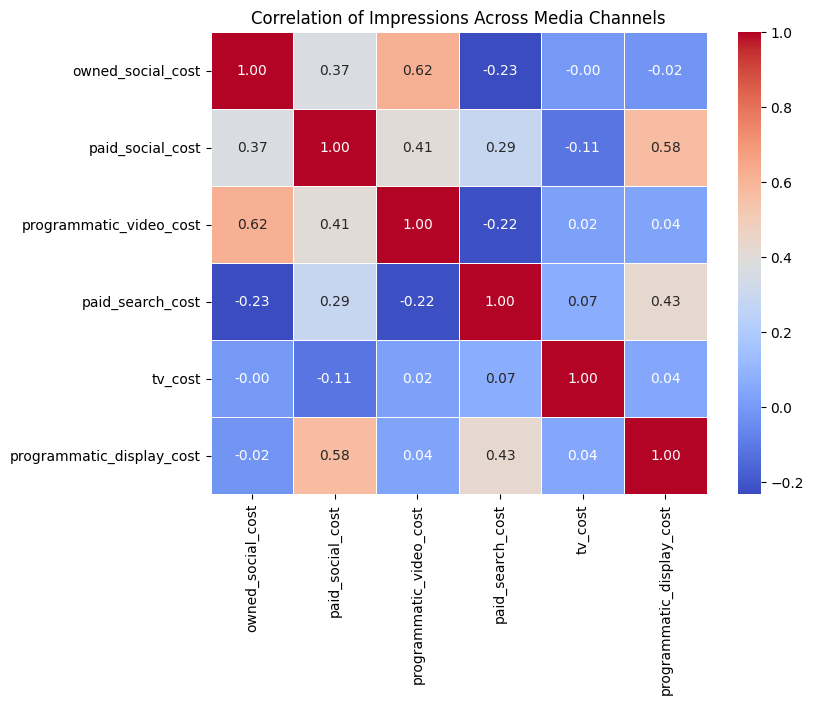

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = media_df.loc[:, ~media_df.columns.isin(['year', 'week_number'])].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Size of the plot
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

# Set the title and display the plot
plt.title("Correlation of Impressions Across Media Channels")
plt.show()


In [24]:
media_df['tv_cost_lag8'] = media_df['tv_cost'].shift(8)
media_df.drop(columns=['tv_cost'], inplace=True)

# filter media columns if requested
media_df = media_df.iloc[8:]
#if media_columns:
#    media_df = media_df[media_columns] 
    
# filter exogenous columns if requested
extra_variables_df = extra_variables_df.iloc[8:]
if exogenous_columns:
    extra_variables_df = extra_variables_df[exogenous_columns]

revenue_df = revenue_df.iloc[8:][[revenue_column]]

In [25]:
media_data = media_df.to_numpy()
#moderator = media_sales_weekly_df[['paid search']].to_numpy()

target = revenue_df.to_numpy()
costs = media_df.sum().to_numpy()
extra_variables = extra_variables_df.to_numpy()


In [26]:
data_size = media_data.shape[0]
# Split and scale data.
split_point = data_size - 23

# Media data train
media_data_train = media_data[:split_point, ...]
#mediator_train = moderator[:split_point, ...]
exogenic_train = extra_variables[:split_point, ...]

# Media data test
media_data_test = media_data[split_point:, ...]
#mediator_test = moderator[split_point:, ...]
exogenic_test = extra_variables[split_point:, ...]

# Target
target_train = target[:split_point].reshape(-1)
target_test = target[split_point:].reshape(-1)

In [27]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
exogenic_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
mediator_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
exogenic_train = exogenic_scaler.fit_transform(exogenic_train)
#mediator_train = mediator_scaler.fit_transform(mediator_train)

media_data_test = media_scaler.transform(media_data_test)
exogenic_test = exogenic_scaler.transform(exogenic_test)
#mediator_test = mediator_scaler.transform(mediator_test)

target_train = target_scaler.fit_transform(target_train)
target_test = target_scaler.transform(target_test)

costs2 = cost_scaler.fit_transform(costs)


In [28]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

In [29]:
media_data_train.shape

(104, 6)

In [30]:
number_warmup=500
number_samples=500


mmm.fit(
    #media=media_data_train + mediator_train * media_data_train,
    media=media_data_train,
    media_prior=costs2,
    target=target_train,
    extra_features=exogenic_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    number_chains=1,
    )

extra_features (104, 5)
extra_features (104, 5)
extra_features (104, 5)


  0%|          | 0/1000 [00:00<?, ?it/s]

extra_features (104, 5)


sample: 100%|██████████| 1000/1000 [00:58<00:00, 17.10it/s, 255 steps of size 1.40e-02. acc. prob=0.92]


extra_features (104, 5)


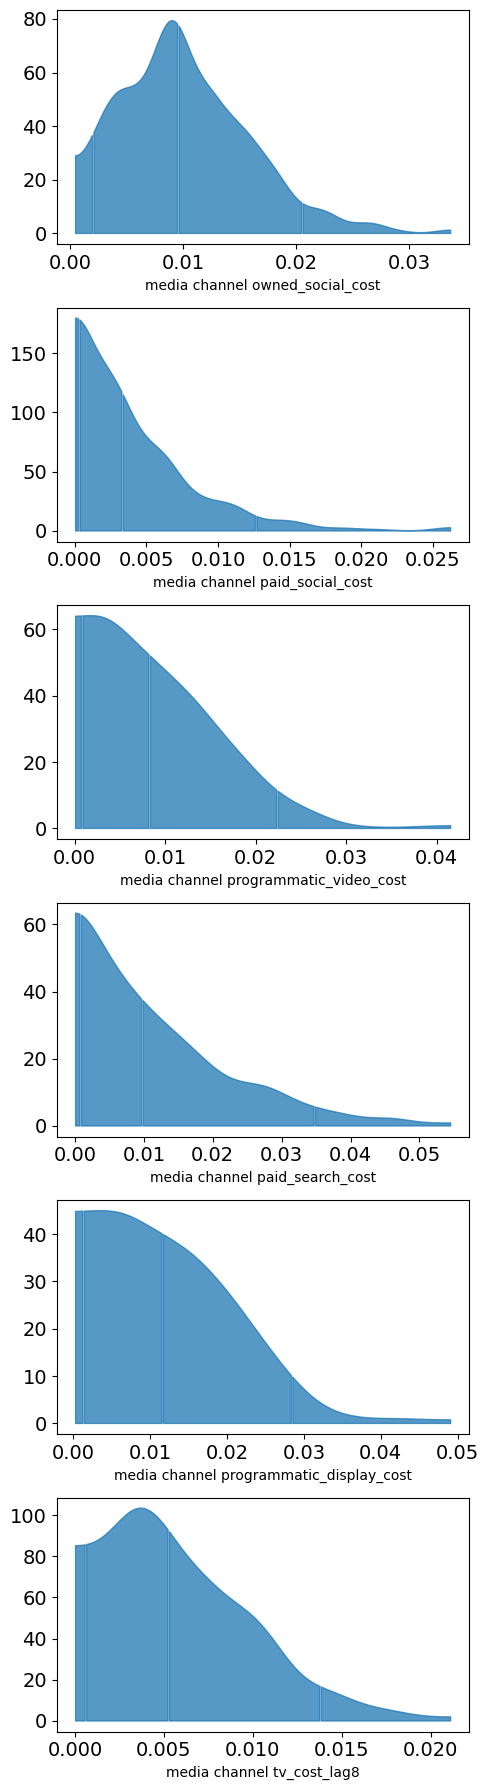

In [31]:

plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_df.columns)

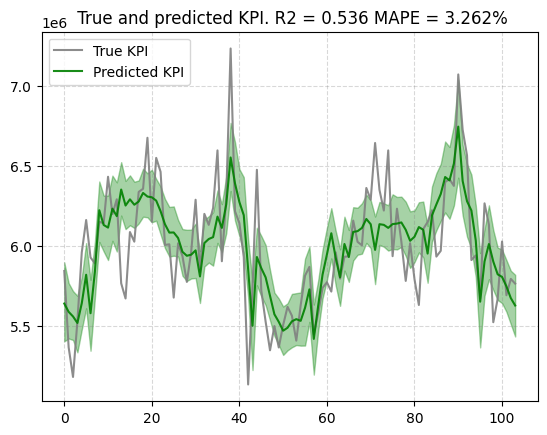

In [32]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [33]:
new_predictions = mmm.predict(media=media_data_test, extra_features=exogenic_test)
new_predictions.shape

extra_features (127, 5)


(500, 23)

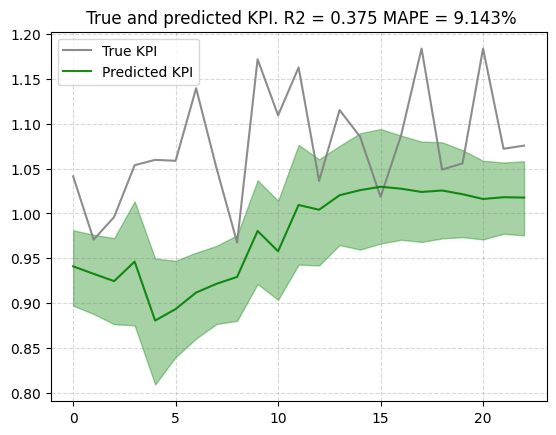

In [34]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:].squeeze()))

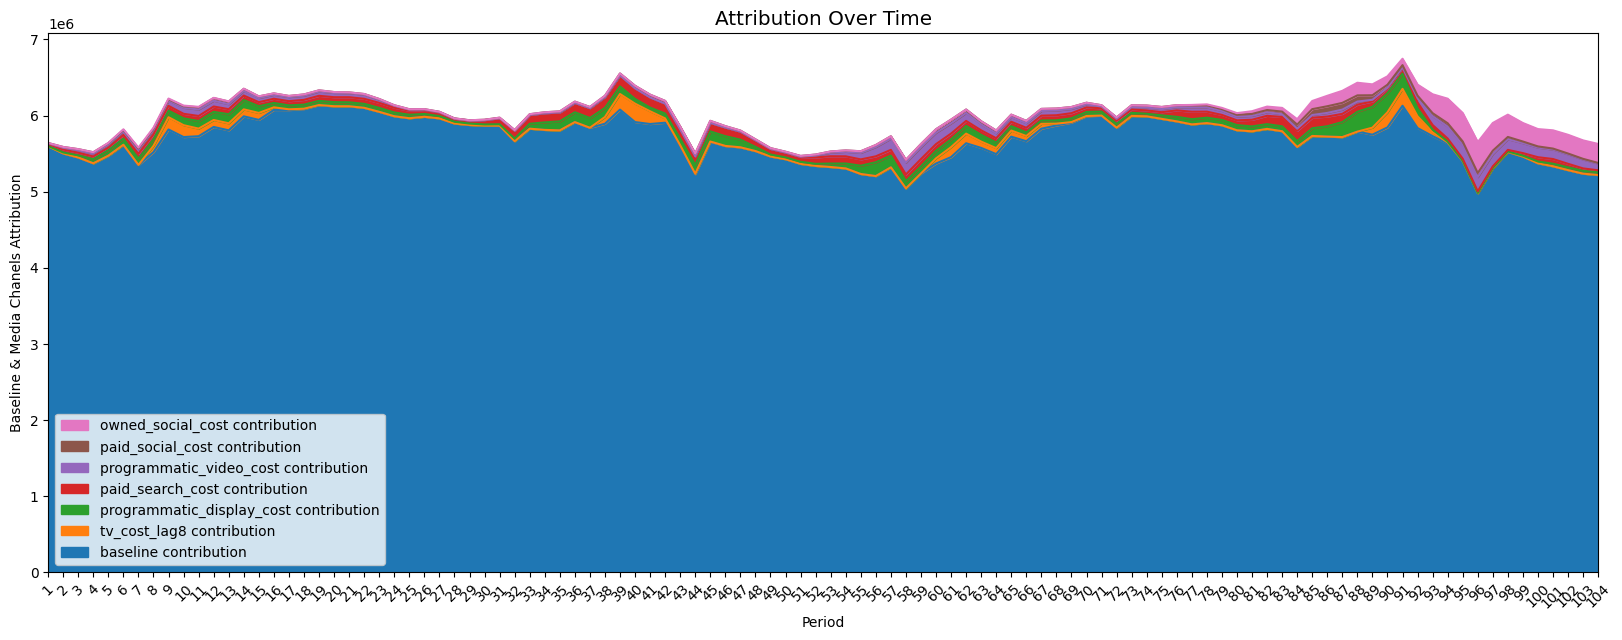

In [35]:

plot.plot_media_baseline_contribution_area_plot(mmm, target_scaler=target_scaler, channel_names=media_df.columns)


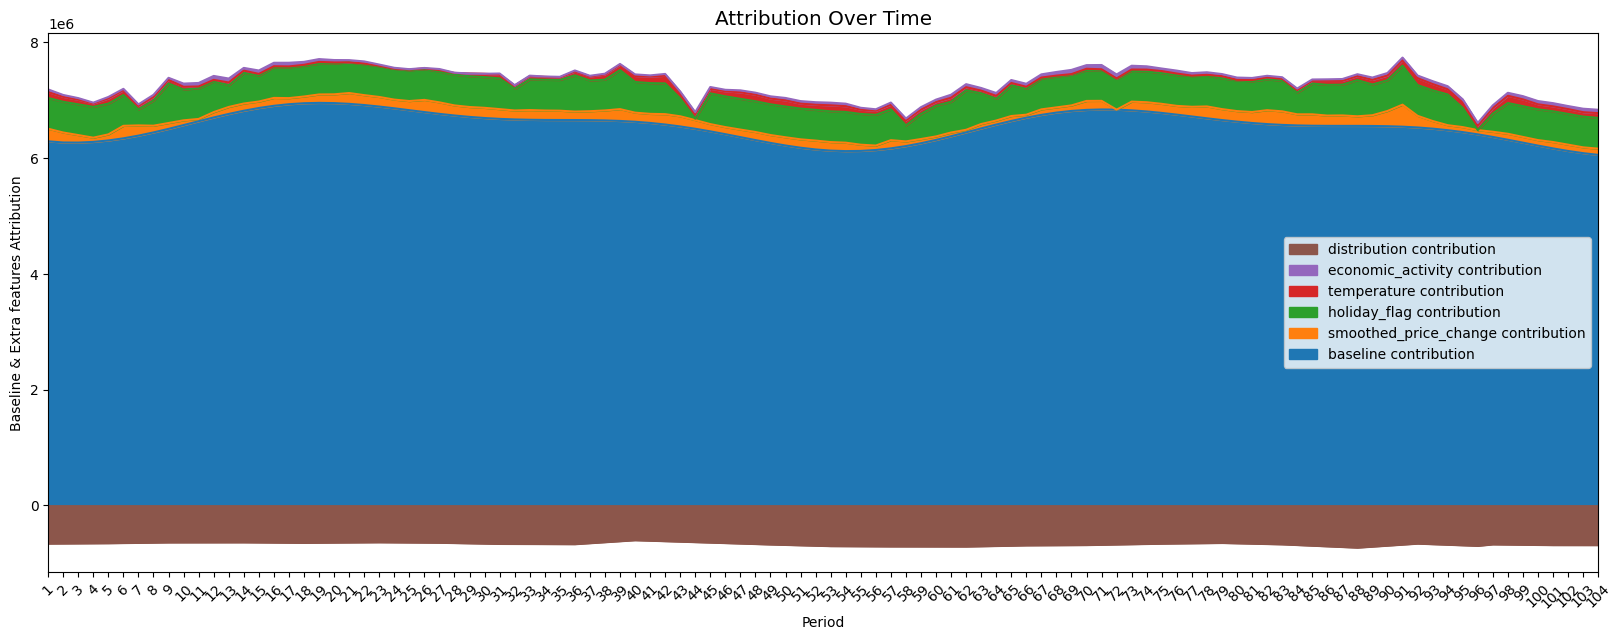

In [36]:
plot.plot_extra_features_baseline_contribution_area_plot(mmm, target_scaler=target_scaler, channel_names=extra_variables_df.columns)

media contribution, media_transformed (500, 104, 6) (500, 6)
media contribution, extra features (500, 5)


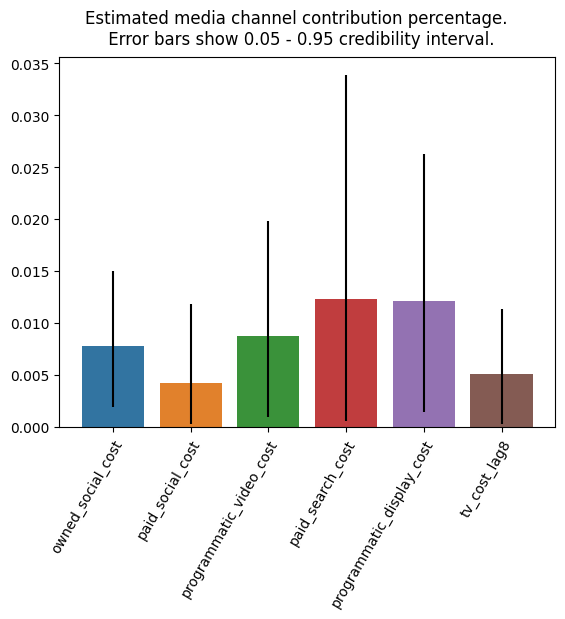

In [37]:
plot.plot_bars_media_metrics(mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)[0], metric_name="contribution percentage", channel_names=media_df.columns)

media contribution, media_transformed (500, 104, 6) (500, 6)
media contribution, extra features (500, 5)


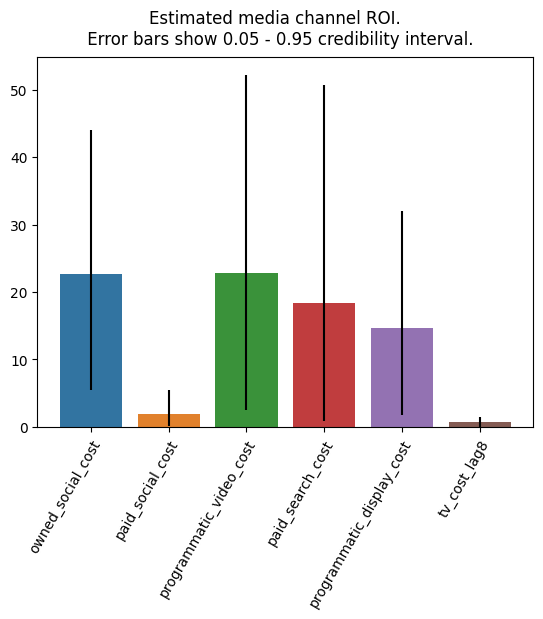

In [38]:
plot.plot_bars_media_metrics(mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)[1], metric_name="ROI", channel_names=media_df.columns)